***Authors:  Jarod Carroll, Daihong Chen, Mihir Bhagat***

# Predicting Customer Churn in SyriaTel

**Data Source: https://www.kaggle.com/becksddf/churn-in-telecoms-dataset**

## Methodology

1. Data Acquisition
   - Get from Kaggle
2. Baseline Model
    - Get features so they are usable in a model
    - Split data into training and holdout
    - Split training data into sub training data and evaluation data
    - Train a stacking model
    - Evaluate the model
3. Impove the model
    - Work with the features
    - Change estimators in the stacking model
    - Tune Hyperparameters
4. Final Model
    - Train on full training set
    - Evaluate on holdout set

#### Import Necessary Packages

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.model_maker import *

## Data Acquisition

The data was downloaded from Kaggle and put into the data folder. The target value was set as the churn column.

In [3]:
df = pd.read_csv('../../data/Customer Churn Data.csv')

y = df['churn']
X = df.drop('churn', axis=1)

The dataset is imbalanced, so we would expect about 85% accuracy if we always assumed that "churn" was False

In [4]:
y.value_counts()

False    2850
True      483
Name: churn, dtype: int64

In [5]:
2850 / (2850 + 483)

0.8550855085508551

The data was then split into a training and holding set then the training data was further broken into a training and testing set. The testing set was used to evaluate if the model improved. The holding set will be used for final model evaluation.

In [6]:
X_full_train, X_holdout, y_full_train, y_holdout = train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_full_train, y_full_train, random_state=42)

## Making a Baseline Model

In order to make a baseline model some features where changed. First, columns for international plan and voicemail plan were converted to integers and unnecessary columns were dropped by `preprocess_data_baseline`. Then the State columns was one hot encoded so it could be used in the model. 

In [7]:
X_train = preprocess_data_baseline(X_train.copy())
X_test = preprocess_data_baseline(X_test.copy())

In [8]:
states = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
    'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
    'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
    'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
    'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
]
ohe = OneHotEncoder(sparse=False, categories=[states], handle_unknown="ignore")
ohe.fit(X_train[['state']])

test_ohe_df = pd.DataFrame(ohe.transform(X_test[['state']]), columns=states, index=X_test.index)
X_test = pd.concat([X_test, test_ohe_df], axis=1)
X_test.drop('state', axis=1, inplace=True)

A stacking model was then trained using the training data and using KNN, random forest classifier, and a gradient boosting classifier as estimators. This model was saved into a pickle file and can be loaded from there.

In [9]:
base_model = read_pickle('../../src/base_model.pickle');

To get an idea of how this model is doing we looked at how it performed on the testing set.

In [10]:
baseline_metrics_dict = metrics(y_test, base_model.predict(X_test))
baseline_metrics = pd.DataFrame(data=baseline_metrics_dict, index=["Baseline Model"])
baseline_metrics

,Accuracy,Precision,Recall,F1
Baseline Model,0.9696,0.9882352941176471,0.8235294117647058,0.8983957219251337


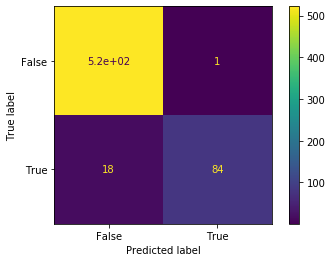

In [11]:
fig, ax = plt.subplots()
plot_confusion_matrix(base_model, X_test, y_test, ax=ax);

## Improving the Model

In order to improve the model there are a couple of things that can be done. First we worked with the features a bit. Very few things led to model improvements but there was one important one. Summing up all of the charge columns led to larger model improvements so that was used in the final model. It was found out that the state column did not contribute to the model so that was removed. \
The next step to improving the model was to change the base estimators. Many were tried but we found that getting rid of KNN and using a logistic regression improved our model. \
After this the hyper parameters of the estimators were changed in orderto fine tune our model. The only change in that led to an improved model was changing the solver in the logistic regression to liblinear.
After optimizing all of these a final model was made.

## Final Model

Using all the improvements the model was saved to a pickle file to be loaded here. The model was trained on the full training set.

In [12]:
final_model = read_pickle('../../src/model.pickle')

This model was then evaluated using the holdout set.

In [13]:
X_holdout = preprocess_data(X_holdout.copy())

In [14]:
final_metrics_dict = metrics(y_holdout, final_model.predict(X_holdout))
final_metrics = pd.DataFrame(data=final_metrics_dict, index=["Final Model"])
final_metrics

,Accuracy,Precision,Recall,F1
Final Model,0.9820143884892086,1.0,0.88,0.9361702127659575


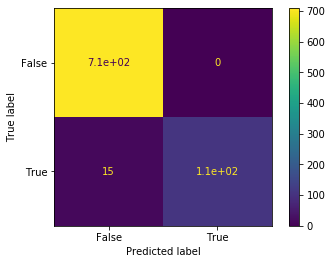

In [15]:
fig, ax = plt.subplots()
plot_confusion_matrix(final_model, X_holdout, y_holdout, ax=ax);

### Metrics Comparison

In [16]:
pd.concat([baseline_metrics, final_metrics])

,Accuracy,Precision,Recall,F1
Baseline Model,0.9696,0.9882352941176471,0.8235294117647058,0.8983957219251337
Final Model,0.9820143884892086,1.0,0.88,0.9361702127659575


As we see the model does very well on the holdout set. Our model has a high accuracy of 98%. The only part the model doesn't do well on is that is sometimes predicts that the customer will not leave when they would.  This explains the 2% of cases that the model predicts incorrectly.